# YOLOv5 for Automatic License Plate Recognition

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F793761%2Fc15e812b3ab9aad2c0694a2e1f7548e9%2FUntitled.png?generation=1590981584876269&alt=media)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ANPR_system

/content/drive/MyDrive/ANPR_system


## Clone Github Repo [YOLOv5](https://github.com/ultralytics/yolov5)

In [32]:
# Clone YOLOv5 code
!git clone https://github.com/rkuo2000/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [3]:
%cd yolov5

/content/drive/MyDrive/ANPR_system/yolov5


In [ ]:
!python utils/benchmarks.py --weights yolov5s.pt --img 640 --device 0

benchmarks: weights=yolov5s.pt, imgsz=640, batch_size=1, data=/content/drive/MyDrive/ANPR_system/yolov5/data/coco128.yaml, device=0, half=False, test=False, pt_only=False, hard_fail=False
YOLOv5 🚀 v6.1-303-gb3ca8d8 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-303-gb3ca8d8 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients

Dataset not found ⚠, missing paths ['/content/drive/MyDrive/ANPR_system/datasets/coco128/images/train2017']
100% 6.66M/6.66M [00:00<00:00, 29.3MB/s]
Dataset download success ✅ (2.4s), saved to /content/drive/MyDrive/ANPR_system/datasets
100% 755k/755k [00:01<00:00, 485kB/s]
val: Scanning '/content/drive/MyDrive/ANPR_system/datasets/coco128/labels/train2017' images and labels...126 found, 2 missing, 0 empty, 0 corrupt: 100% 128/128 [00:00<00:00, 270.98it/s]
val: New cache created: /content/drive/MyDrive/ANPR_system/datasets/coco128/labels/train2017.

In [19]:
!echo "train: Dataset/train/images" > data/alpr.yaml
!echo "val:   Dataset/train/images" >> data/alpr.yaml

!echo "nc : 1" >> data/alpr.yaml
!echo "names: ['license_plate']" >> data/alpr.yaml

!cat data/alpr.yaml

train: Dataset/train/images
val:   Dataset/train/images
nc : 1
names: ['license_plate']


## Prepare Dataset

In [20]:
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

In [21]:
FILE_ROOT = "/content/drive/MyDrive/ANPR_system/"
IMAGE_PATH = FILE_ROOT + "/Dataset/images"  
ANNOTATIONS_PATH = FILE_ROOT + "Dataset/annotations"

DATA_ROOT = "Dataset/"
DEST_IMAGES_PATH = "train/images"
DEST_LABELS_PATH = "train/labels"

In [22]:
!mkdir -p Dataset/train/labels

In [23]:
# copy images
!mkdir -p Dataset/train
!cp -rf /content/drive/MyDrive/ANPR_system/Dataset/images Dataset/train

In [25]:
# move images from training to validation set
!mkdir -p Dataset/val
!mv Dataset/train/images/Cars1*.png Dataset/val

In [26]:
# Convert COCO Annotations to YOLOv5 Labels

def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]
    
def save_file(img_jpg_file_name, size, img_box):
    classes = ['license']
    save_file_name = DATA_ROOT + DEST_LABELS_PATH + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:                  
        #cls_num = classes.index(box[0]) # find class_id
        cls_num = 0
        new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)
    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [27]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

file name:  Cars0.xml
/content/drive/MyDrive/ANPR_system/Dataset/annotations/Cars0.xml
box:(c,xmin,ymin,xmax,ymax) licence 226 125 419 173
Dataset/train/labels/Cars0.txt
file name:  Cars110.xml
/content/drive/MyDrive/ANPR_system/Dataset/annotations/Cars110.xml
box:(c,xmin,ymin,xmax,ymax) licence 286 133 328 159
Dataset/train/labels/Cars110.txt
file name:  Cars1.xml
/content/drive/MyDrive/ANPR_system/Dataset/annotations/Cars1.xml
box:(c,xmin,ymin,xmax,ymax) licence 134 128 262 160
Dataset/train/labels/Cars1.txt
file name:  Cars120.xml
/content/drive/MyDrive/ANPR_system/Dataset/annotations/Cars120.xml
box:(c,xmin,ymin,xmax,ymax) licence 159 178 250 200
Dataset/train/labels/Cars120.txt
file name:  Cars104.xml
/content/drive/MyDrive/ANPR_system/Dataset/annotations/Cars104.xml
box:(c,xmin,ymin,xmax,ymax) licence 195 266 244 282
Dataset/train/labels/Cars104.txt
file name:  Cars118.xml
/content/drive/MyDrive/ANPR_system/Dataset/annotations/Cars118.xml
box:(c,xmin,ymin,xmax,ymax) licence 193 1

In [28]:
# move images from training to validation set

!mkdir -p Dataset/val/labels
!mv Dataset/train/labels/Cars1*.txt Dataset/val/labels

In [29]:
!ls Dataset/val/labels

Cars100.txt  Cars118.txt  Cars135.txt  Cars152.txt  Cars16.txt	 Cars187.txt
Cars101.txt  Cars119.txt  Cars136.txt  Cars153.txt  Cars170.txt  Cars188.txt
Cars102.txt  Cars11.txt   Cars137.txt  Cars154.txt  Cars171.txt  Cars189.txt
Cars103.txt  Cars120.txt  Cars138.txt  Cars155.txt  Cars172.txt  Cars18.txt
Cars104.txt  Cars121.txt  Cars139.txt  Cars156.txt  Cars173.txt  Cars190.txt
Cars105.txt  Cars122.txt  Cars13.txt   Cars157.txt  Cars174.txt  Cars191.txt
Cars106.txt  Cars123.txt  Cars140.txt  Cars158.txt  Cars175.txt  Cars192.txt
Cars107.txt  Cars124.txt  Cars141.txt  Cars159.txt  Cars176.txt  Cars193.txt
Cars108.txt  Cars125.txt  Cars142.txt  Cars15.txt   Cars177.txt  Cars194.txt
Cars109.txt  Cars126.txt  Cars143.txt  Cars160.txt  Cars178.txt  Cars195.txt
Cars10.txt   Cars127.txt  Cars144.txt  Cars161.txt  Cars179.txt  Cars196.txt
Cars110.txt  Cars128.txt  Cars145.txt  Cars162.txt  Cars17.txt	 Cars197.txt
Cars111.txt  Cars129.txt  Cars146.txt  Cars163.txt  Cars180.txt  Cars198.txt
Ca

## YOLOv5 Training

In [30]:
!python train.py --img 416 --batch 16 --epochs 250 --data data/alpr.yaml --cfg models/yolov5s.yaml

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/alpr.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=250, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch && git config --get remote.origin.url' timed out after 5 seconds
requirements: ipython not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /content/drive/MyDrive/ANPR_system/yolov5/requirements.txt
requirements: ⚠️ Restart r

## YOLOv5 Detect

In [35]:
!python detect.py --source ../Dataset/Test --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

detect: weights=['runs/train/exp/weights/best.pt'], source=../Dataset/Test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-303-gb3ca8d8 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients
image 1/6 /content/drive/MyDrive/ANPR_system/Dataset/Test/IMG20211207080334.jpeg: 640x320 1 license_plate, Done. (0.013s)
image 2/6 /content/drive/MyDrive/ANPR_system/Dataset/Test/IMG20211207080344.jpeg: 640x320 1 license_plate, Done. (0.010s)
image 3/6 /content/drive/MyDrive/ANPR_system/Dataset/Test/IMG20211207080504.jpeg: 640x320 1 license_plate, Done. (0.009s)
image 4/6 /

### Display Detected Images

In [36]:
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [37]:
path = 'runs/detect/exp/'
image_ls = glob.glob(path +'*.jpeg')

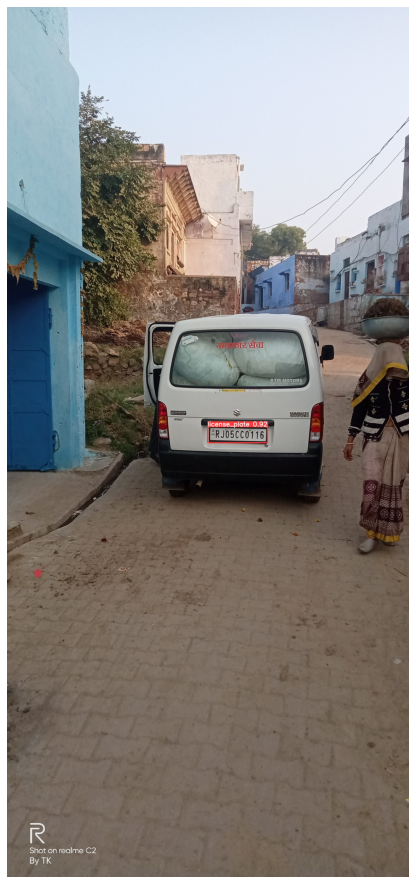

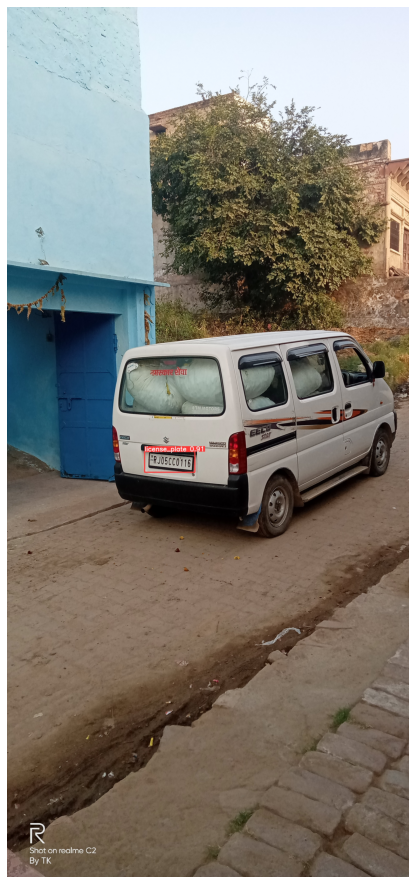

In [38]:
for image_path in image_ls[:2]:
  image = cv2.imread(image_path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.figure(figsize=(18, 16))
  ax = fig.gca()
  ax.grid(False)
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.axis('off')

## Save model as ONNX model

In [ ]:
!nvidia-smi

Tue Nov 22 16:16:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |████████████████▎               | 834.1 MB 1.3 MB/s eta 0:10:03tcmalloc: large alloc 1147494400 bytes == 0x3a410000 @  0x7f3e73471615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████▋           | 1055.7 MB 1.2 MB/s eta 0:08:04tcmalloc: large alloc 1434370048 bytes == 0x7ea66000 @  0x7f3e73471615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |██████████████████████████▏     | 

In [ ]:
%cd /content/drive/MyDrive/ANPR_system/yolov5

/content/drive/MyDrive/ANPR_system/yolov5


In [ ]:
!python export.py --weights runs/train/exp/weights/best.pt --device 0 --include onnx

export: data=data/coco128.yaml, weights=['runs/train/exp/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=0, half=False, inplace=False, train=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v6.1-303-gb3ca8d8 Python-3.7.15 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from runs/train/exp/weights/best.pt with output shape (1, 25200, 6) (13.7 MB)

ONNX: starting export with onnx 1.12.0...
ONNX: export success, saved as runs/train/exp/weights/best.onnx (27.2 MB)

Export complete (6.37s)
Results saved to /content/drive/MyDrive/ANPR_system/yolov5/runs/train/exp/weights
Detect:          python detect.py --weights runs/train/exp/weights/best.onnx 
Validate:        python val.py --weig

In [ ]:
!cp -R runs/train/exp/weights/best.onnx /content/drive/MyDrive/ANPR_system/